In [8]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
from importlib import reload
import functions
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np
import math
reload(functions)

<module 'functions' from 'c:\\Python64\\ADAML_GW\\adaml-ml-project\\functions.py'>

In [2]:
#Read dataset
path = "household_power_consumption.txt"
df = functions.load_data(path)

#Preprocess dataset and convert to hourly
df_hourly = functions.preprocess_data(df).reset_index()
df_hourly.head()

,datetime,Global_active_power,Global_reactive_power,Global_intensity,Voltage,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-17 00:00:00,1.882467,0.102433,8.126667,240.961833,0.0,0.466667,0.000000
1,2006-12-17 01:00:00,3.349400,0.136933,14.246667,240.448333,0.0,25.233333,0.000000
2,2006-12-17 02:00:00,1.587267,0.078233,6.870000,245.818667,0.0,0.566667,0.000000
3,2006-12-17 03:00:00,1.662200,0.079533,7.206667,244.513500,0.0,0.766667,0.000000
4,2006-12-17 04:00:00,2.215767,0.093467,9.333333,243.855500,0.0,0.566667,8.883333


In [3]:
#Add time variables: weekday, hour and day of year. Use sin/cosine transforms
df_hourly["hour_sin"] = np.sin(2*np.pi*(df_hourly["datetime"].dt.hour)/24)
df_hourly["hour_cos"] = np.cos(2*np.pi*(df_hourly["datetime"].dt.hour)/24)

df_hourly["weekday_sin"] = np.sin(2*np.pi*(df_hourly["datetime"].dt.weekday)/7)
df_hourly["weekday_cos"] = np.cos(2*np.pi*(df_hourly["datetime"].dt.weekday)/7)

df_hourly["day_of_year_sin"] = np.sin(2*np.pi*(df_hourly["datetime"].dt.day_of_year)/365)
df_hourly["day_of_year_cos"] = np.cos(2*np.pi*(df_hourly["datetime"].dt.day_of_year)/365)


In [4]:
class EnergyData(Dataset):
    def __init__(self, features, targets, window,horizon):
        self.features = features
        self.targets = targets
        self.window = window
        self.horizon = horizon
        
    def __getitem__(self, index):
        x = self.features[index:index+self.window]
        y = self.targets[(index+self.window):(index+self.window+self.horizon)]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
    
    def __len__(self):
        return len(self.features) - self.window - self.horizon

In [5]:
class Seq2SeqLSTM(nn.Module):
    def __init__(self, n_features, hidden_size, num_layers,output_size):
        super().__init__()
        self.encoder = nn.LSTM(n_features,hidden_size,num_layers,batch_first=True,dropout=0.2)
        self.decoder = nn.LSTM(1,hidden_size,num_layers,batch_first=True,dropout=0.2)
        self.fc = nn.Linear(hidden_size,1)
        self.output_size = output_size
    def forward(self,X):
        # Encoding
        _, (h,c) = self.encoder(X)
        
        #Input for decoder
        decoder_input = torch.zeros(X.size(0),1,1,device=X.device)
        outputs = []

        for i in range(self.output_size):
            out, (h,c) = self.decoder(decoder_input, (h,c))
            y = self.fc(out)
            outputs.append(y)
            decoder_input = y
        return torch.cat(outputs,dim=1)
    


class RNNForecastModel(nn.Module):
    def __init__(self, n_features, hidden_size, output_size, n_layers=2,device="cpu"):
        super().__init__()
        self.n_features = n_features
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.device = device
        self.encoder = nn.RNN(n_features, hidden_size, n_layers, batch_first=True,nonlinearity="tanh",dropout=0.2) #Encoder
        self.decoder = nn.RNN(1,hidden_size,n_layers, batch_first=True,nonlinearity="tanh",dropout=0.2) #Decoder
        self.fc = nn.Linear(hidden_size, 1) # output layer
        
    def forward(self, X):
        #Encoding
        _, h = self.encoder(X)
        decoder_input = torch.zeros(X.size(0),1,1,device=self.device)
        outputs  = []
        for i in range(self.output_size):
            out, h = self.decoder(decoder_input,h)
            y = self.fc(out)
            outputs.append(y)
            decoder_input = y
        return torch.cat(outputs,dim=1)


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # (1, max_len, d_model)
        self.register_buffer("pe", pe)

    def forward(self, x):
        # x: (B, S, d_model)
        seq_len = x.size(1)
        return x + self.pe[:, :seq_len, :]


class TransformerModel(nn.Module):
    def __init__(
        self,
        num_features,
        d_model=128,
        nhead=4,
        num_layers=3,
        dim_feedforward=128,
        max_len=5000,
        horizon=24,
        dropout=0.2,
    ):
        super().__init__()
        self.input_proj = nn.Linear(num_features, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len=max_len)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.fc_out = nn.Linear(d_model, horizon)

    def forward(self, x):
        # x: (B, S, F)
        x = self.input_proj(x)      # (B, S, d_model)
        x = self.pos_encoder(x)     # (B, S, d_model)
        x = self.encoder(x)         # (B, S, d_model)

        # Average over time dimension
        x = x.mean(dim=1)           # (B, d_model)

        out = self.fc_out(x)        # (B, horizon)
        return out

In [10]:
last_year = len(df_hourly) - 24*365

# Split data into training/validation and test sets, last year for testing
train_val_data = df_hourly.iloc[:last_year]
test_data = df_hourly.iloc[last_year:]
nFolds = 5 # using 5 folds for time series cross-validation

tscv = TimeSeriesSplit(n_splits=5, test_size=73*24)

Y = train_val_data["Global_active_power"].values
X = train_val_data.iloc[:, 1:len(train_val_data.columns)].values

folds = []

for i, (train_index, test_index) in enumerate(tscv.split(X, Y)):
    folds.append((train_index, test_index))

In [7]:
folds

[(array([    0,     1,     2, ..., 17037, 17038, 17039], shape=(17040,)),
  array([17040, 17041, 17042, ..., 18789, 18790, 18791], shape=(1752,))),
 (array([    0,     1,     2, ..., 18789, 18790, 18791], shape=(18792,)),
  array([18792, 18793, 18794, ..., 20541, 20542, 20543], shape=(1752,))),
 (array([    0,     1,     2, ..., 20541, 20542, 20543], shape=(20544,)),
  array([20544, 20545, 20546, ..., 22293, 22294, 22295], shape=(1752,))),
 (array([    0,     1,     2, ..., 22293, 22294, 22295], shape=(22296,)),
  array([22296, 22297, 22298, ..., 24045, 24046, 24047], shape=(1752,))),
 (array([    0,     1,     2, ..., 24045, 24046, 24047], shape=(24048,)),
  array([24048, 24049, 24050, ..., 25797, 25798, 25799], shape=(1752,)))]

In [ ]:

input_size = X.shape[1] # number of features
hidden_size = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss_fn = nn.MSELoss()
n_epochs = 50
learning_rate = 2.5*10**(-5)
window = 24
foldLosses = [[] for _ in range(nFolds)]
trainLosses = [[] for _ in range(nFolds)]
valLosses = [[] for _ in range(nFolds)]



preds = []
horizon = 24

n_features  = 13
hidden_size = 32
num_layers = 2
output_size = 24

#Path for saving model weights during training
model_path = "adaml_cv.pth"



truevalids = []
for window in [24,48,72,96,120,144,168]:
    #Arrays for average/std of rmse values
    rmse_averages = [[] for _ in range(nFolds)]
    rmse_stds = [[] for _ in range(nFolds)]
    foldLosses = [[] for _ in range(nFolds)]
    trainLosses = [[] for _ in range(nFolds)]
    valLosses = [[] for _ in range(nFolds)]
    for i in range(len(folds)):
        scalerX = MinMaxScaler()
        scalerY = MinMaxScaler()
        train_idx, val_idx = folds[i]
        train_X, val_X = X[train_idx], X[val_idx]
        train_Y, val_Y = Y[train_idx], Y[val_idx]
        train_X = scalerX.fit_transform(train_X)
        val_X = scalerX.transform(val_X)
        train_Y = scalerY.fit_transform(train_Y.reshape(-1, 1))
        val_Y = scalerY.transform(val_Y.reshape(-1, 1))
        trainData = EnergyData(train_X, train_Y, window,horizon)
        valData = EnergyData(val_X, val_Y, window,horizon)
        trainLoader = DataLoader(trainData, batch_size=128, shuffle=True)
        valLoader = DataLoader(valData, batch_size=128, shuffle=False)
        #model = Seq2SeqLSTM(n_features=n_features,hidden_size=hidden_size,num_layers=num_layers,output_size=output_size).to(device)
        #model = RNNForecastModel(n_features, hidden_size, output_size,device=device).to(device)
        model = TransformerModel(num_features=n_features, horizon=horizon).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        #Minimun validloss
        min_valid_loss = np.inf
        #Value used for early stopping
        no_update_steps = 0
        #Training
        for epoch in range(n_epochs):   
            model.train()
            epoch_loss = 0
            for X_batch, y_batch in trainLoader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                #print("Batch X shape:", X_batch.shape)
                #print("Batch y shape:", y_batch.shape)
                #Prediction and loss
                pred=model(X_batch)
                y_batch = y_batch.view(pred.shape)
                #print("Prediction shape:", pred.shape)
                #print("Prediction: ", pred)
                loss=loss_fn(pred,y_batch)
                epoch_loss += loss.item()
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                # pred_real = scalerY.inverse_transform(pred.detach().cpu().numpy())
                # y_real = scalerY.inverse_transform(y_batch.detach().cpu().numpy())
                # print(pred_real, y_real)
            model.eval()
            with torch.inference_mode():
                val_loss = 0
                for X_batch, y_batch in valLoader:
                    X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                    pred = model(X_batch)
                    y_batch = y_batch.view(pred.shape)
                    loss = loss_fn(pred, y_batch)
                    val_loss += loss.item()
                    #preds.append(pred.detach().cpu().numpy())
                    #truevalids.append(y_batch.detach().cpu().numpy())
            if (epoch+1)%10 == 0:
                print(f"Window: {window} | Fold {i+1}, Epoch {epoch+1} / {n_epochs}, Training Loss: {epoch_loss/len(trainLoader):.4f}, Validation Loss: {val_loss/len(valLoader):.4f}")
            #trainLosses[i].append(epoch_loss/len(trainLoader))
            #valLosses[i].append(val_loss/len(valLoader))
            if val_loss < min_valid_loss:
                torch.save(model.state_dict(),model_path)
                min_valid_loss = val_loss
                no_update_steps = 0
            else:
                no_update_steps += 1
            if no_update_steps > 20:
                break
        foldLosses[i].append(min_valid_loss/len(valLoader)) # last validation loss of the fold (not necessary but easy way :D)
        #Calculate RMSE for fold
        model.load_state_dict(torch.load(model_path,weights_only=True))
        model.eval()
        rmse_values = []
        with torch.no_grad():
            for index in range(valData.__len__()):
                X_actual, y_actual = valData.__getitem__(index)
                y_actual = scalerY.inverse_transform(y_actual)
                y_pred = model(X_actual.unsqueeze(0).to(device)).squeeze(0)
                y_pred = scalerY.inverse_transform(y_pred.detach().cpu().numpy().reshape(-1,1))
                rmse_values.append(root_mean_squared_error(y_actual,y_pred))
        rmse_averages[i].append(np.mean(rmse_values))
        rmse_stds[i].append(np.std(rmse_values))

    print(f"________________________________\nLookback window {window}:")
    print(f"Number of epochs used in training {epoch+1}")
    print("Minimum avg validation losses")
    print(np.array(foldLosses)[:,0])
    print("Average RMSE values")
    print(np.array(rmse_averages)[:,0])
    print("STD RMSE values")
    print(np.array(rmse_stds)[:,0])

    #torch.save(model.state_dict(), f"models/rnn_fold_{i+1}.pth")
    #break # fold 1 test

Window: 24 | Fold 1, Epoch 10 / 50, Training Loss: 0.0206, Validation Loss: 0.0208


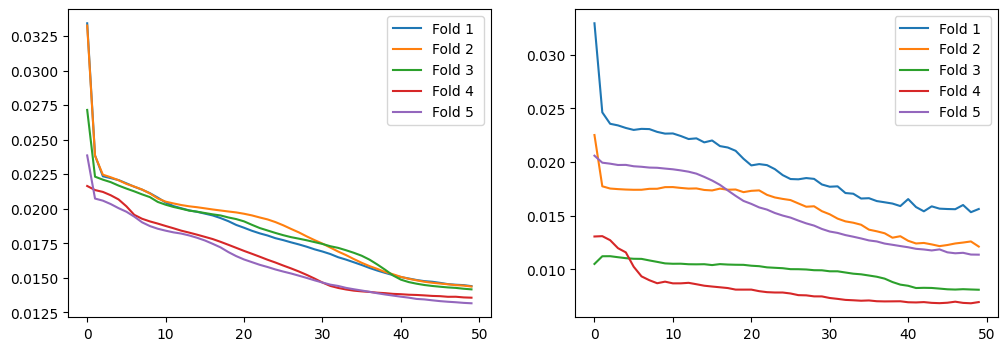

In [ ]:
plt.figure(figsize=(12,4))
for i in range(5):
    plt.subplot(1,2,1)
    plt.plot(trainLosses[i],label=f"Fold {i+1} ")
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(valLosses[i],label=f"Fold {i+1} ")
    plt.legend()